In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from time import mktime
# import 3d -> 2d function
from convert2d import convert2d, Rotate_z, Rotate_y
from Helpers_fixed import convert_cartesian,convert_ephemeri,generate_ephemeri, scale, scale_test, unscale_test, grad_descent2  
from epicycloid_process_data import reverse_z_alignment


In [3]:
# from google.colab import  drive
# drive.mount('/drive')

In [4]:
# !ls '/drive/My Drive/PROJ S'

## Problem Statement

Observing true, Earth-centered astronomical data, the orbits around the earth form a complex shape with epicycles - specifically, some form of prolate epicycloid. After a certain period of time, the planet will begin to repeat this epicycloid pattern only this new "cycle" will be slightly offset. Since the new cycle does not begin at the same starting point as the previous orbit, the orbits appear to be rotated when compared to the previous cycle. By analyzing the data, we have found that this rotation factor seems to remain consistent over many cycles and thus, could be learned effectively under parameter estimation.

In this notebook, we attempt to model the rotation between two cycles of a specific planets geocentric orbit as a means of making out of sample positioning predictions. The grad_descent2 function uses the derivative of a 2D rotation matrix to learn the theta that minimizes the euclidean distance between the second train cycle and the rotated first train cycle.

We then use this theta, multiplied by a factor representing how far the test data is from the first train cycle, to make our predictions. It is also necessary to introduce an "offset" which accounts for a difference in the start points of data in two consecutive cycles. This parameter is quickly discovered manually and in principal is simply a step in formatting data.

## Preprocessing

In this stage, we first take in our generated, earth-centered data and rotate the epicycloid plane to two dimensions. 

Next, we spilt between training and test sets. Note, this approach is different form a normal train/test split. We need exactly 2 cycles of data for training and test points can be queried a-la-cart using the generate_ephemeri function. Therefore, the test set itself is processed just for convenience and plotting.  

After splitting, we scale x, y data points to be in range [-1, 1] using the train and test distributions respectively. The values for x, y are (no pun intended) astronomically high as the measurements are in kilometers. Thus, we need to scale down the values or else gradient descent will overflow quickly.

Our gradient descent algorithm functions in the 2D space and so to obtain 3D predictions we simply inverse the transformation we performed to rotate the 3D epicycloid to convert it to 2D.

In [64]:
def preprocess(planet):

    jup, rotheta, phi, normal = convert2d(file='../../Data'+planet+'4x.csv')

    idx = len(jup)
    jup_test = jup[idx//2:]
    jup_train = jup[:idx//2]
    if planet =='Uranus':
        jup, rotheta, phi, normal = convert2d(file=planet+'3x.csv')
        jup_test = jup[2*idx//3:]
        jup_train = jup[:2*idx//3]
    elif planet == 'Neptune':
        jup_train = jup[:-3000]
        jup_test = jup[-3000:]


    y_scl = scale(jup_train["Y"], upper = 1.0, lower=-1.0)
    x_scl = scale(jup_train["X"], upper = 1.0, lower=-1.0)
    y_scl_test = scale(jup_test["Y"], upper = 1.0, lower=-1.0)
    x_scl_test = scale(jup_test["X"], upper = 1.0, lower=-1.0)
#     cycles = 2
#     train_n = len(x_scl)
#     q = len(jup)
#     t = np.linspace(0, cycles*2*np.pi,train_n)
    print('train: ',jup_train.shape,'test: ',jup_test.shape)
    return x_scl, y_scl, x_scl_test,y_scl_test, jup_train, jup_test, rotheta, phi, normal

## Regressor Class

In [49]:
class RotationRegressor: 
    def __init__(self, planet):
        self.planet = planet
        self.params = {}
        self.n = 0
        self.t = 0
        self.times = np.zeros(2)
        self.x_train = np.zeros(2)
        self.y_train = np.zeros(2)
        self.cycles = 2
        self.rot = 0
        self.cycle_len = 0
        
        if planet == "Jupiter" or planet == "jupiter":
            self.params = {'lr':0.0001, 'iter':3000, 'init_weight':0.1, 'offset':15}
            self.planet = 'Jupiter'
        elif planet == "Uranus" or planet == "uranus":
            self.params = {'lr':0.0001, 'iter':3000, 'init_weight':0.1, 'offset':1}
            self.planet = 'Uranus'
        elif planet == "Neptune" or planet == "neptune":
            self.params = {'lr':0.0001, 'iter':3000, 'init_weight':0.1, 'offset':5}
            self.planet = 'Neptune'
        elif planet == "Mercury" or planet == "mercury":
            self.params = {'lr':0.0001, 'iter':10000, 'init_weight':0.3, 'offset':10}
            self.planet = 'Mercury'
        elif planet == "Venus" or planet == "venus":
            self.params = {'lr':0.0001, 'iter':10000, 'init_weight':0.1, 'offset':30}
            self.planet = 'Venus'
        elif planet == "Mars" or planet == "mars":
            self.params = {'lr':0.000001, 'iter':10000, 'init_weight':-0.2, 'offset':15}
            self.planet = 'Mars'     
        elif planet == "Saturn" or planet == "saturn":
            self.params = {'lr':0.0001, 'iter':10000, 'init_weight':0.1, 'offset':60}
            self.planet = 'Saturn'   
        self.theta = self.params['init_weight']
    def fit(self, times, x, y):
        # x, y scaled in [-1, 1]
        # two cycles used for train
        self.times = times
        self.n = len(x)
        self.t = np.linspace(0, self.cycles*2*np.pi,self.n)
        self.x_train = x
        self.y_train = y
        
        theta = self.theta
        self.preds = []
        ## Uranus' orbit repeats almost perfectly, their is no implied rotation between cycles
        if self.planet == "Uranus":
            self.theta = 0
            return self
        thetas, losses = grad_descent2(self.t, x, y, theta, self.params['lr'], self.params['iter'], 
                                       offset=self.params['offset'])
        theta_hat = thetas[np.argmin(losses)]
        self.theta = theta_hat
        return self 

    def predict(self, t_test):
#         pass
        
        x1 = self.x_train[:self.n//2]
        y1 = self.y_train[:self.n//2]
        x2 = self.x_train[self.n//2:]
        y2 = self.y_train[self.n//2:]  
#         print(self.times[0])
        start_time = datetime.strptime(self.times[0][:19],'%Y-%m-%d %H:%M:%S')
        test_time = datetime.strptime(t_test,'%Y-%m-%d %H:%M:%S')
        duration = test_time - start_time                        
        time_diff = duration.total_seconds()/(3600*24) 
        cycle_len = (datetime.strptime(self.times[len(x1)][:19],'%Y-%m-%d %H:%M:%S') - 
                        datetime.strptime(self.times[0][:19],'%Y-%m-%d %H:%M:%S')).total_seconds()/(3600*24) 
        self.cycle_len = cycle_len
        cycle_shift = np.floor(time_diff/cycle_len)
#         print(cycle_shift)
        cycle_dec = time_diff/cycle_len - np.floor(time_diff/cycle_len)
        
        thet = self.theta*cycle_shift
        R = np.array([[np.cos(thet), np.sin(thet)],
                      [-np.sin(thet), np.cos(thet)]])

        carts = np.vstack((x1, y1))
        carts2 = np.vstack((x2, y2))
        self.rot = R @ carts
        self.rot_next = R @ carts2
        adj =int(self.params['offset'] * cycle_shift)
        if self.planet == 'Uranus':
            adj = int(self.params['offset'] * min(cycle_shift, 1))
        
        try:
            pred = self.rot[:, adj+int(np.floor(self.n//2 * cycle_dec))]
        except IndexError:
            next_cycle= adj+int(np.floor(self.n//2 * cycle_dec)) % self.n//2
            pred = self.rot_next[:, next_cycle]        

        self.pred = pred
        return pred
    def plot(self, x_test, y_test, flatx, flaty, pred_3d, test_3d,test_row2, surrounding=True):
        fig2 = plt.figure(figsize=(20,20))
        ax2 = fig2.add_subplot(121)
        x1 = self.x_train[:self.n//2]
        y1 = self.y_train[:self.n//2]
        ax2.plot(x1, y1, label='train')
        ax2.plot(self.rot[0, :], self.rot[1, :], c = 'orange', label='rotation (pred)')
        if surrounding:    
            ax2.plot(flatx, flaty, c = 'red',label='test')
        ax2.scatter(x_test, y_test, c='black', label='test point', s=70)
        ax2.scatter(self.pred[0], self.pred[1], c='green', label='predicted point', s=70)
        ax2.set_aspect('equal', adjustable="box")
        
        fig = plt.figure(figsize=(50,50))
        ax = fig.gca(projection='3d')

        ax.scatter(pred_3d[0], pred_3d[1],pred_3d[2], label='pred', c='green', s=1000)
        ax.scatter(test_3d[0], test_3d[1],test_3d[2], s=1000)
        ax.scatter(0,0,0, s=3000, label='Earth', c='cyan')
        ax.plot(test_row2['X'], test_row2['Y'],test_row2['Z'])
        vec = np.vstack((pred_3d, test_3d))
        ax.plot(vec[:,0],vec[:,1],vec[:,2])
        plt.legend()
        plt.show()
        

In [47]:
def process_test(planet, test_pnt, surround_range, rotheta, phi, normal, jup_train):
    """ takes planet string and test_pnt (datetime string)
    and produces data for plotting 2D and 3D"""
    test_row=generate_ephemeri(planet, [test_pnt], 'multiple mirror telescope')

    flat = Rotate_z(np.array((test_row['X'][0], test_row['Y'][0], test_row['Z'][0])), -rotheta)
    flat = Rotate_y(flat, -phi)
    test_row2=generate_ephemeri(planet, surround_range, 'multiple mirror telescope')
    flat2 = Rotate_z(test_row2[['X', 'Y', 'Z']].to_numpy(), -rotheta)
    flat2 = Rotate_y(flat2, -phi)
    flat2_x = scale(flat2[:,0], upper=1, lower=-1) 
    flat2_y = scale(flat2[:,1], upper=1, lower=-1) 
       
    x_test=scale_test(flat[0], jup_train['X'])
    y_test=scale_test(flat[1], jup_train['Y'])
    
    # convert 3D
    
    return x_test, y_test, flat2_x, flat2_y, test_row2


In [58]:
def format_points(preds, test_pnt, jup_train, normal):
    test_row=generate_ephemeri(planet, [test_pnt], 'multiple mirror telescope')
    test_3d = [test_row['X'][0], test_row['Y'][0], test_row['Z'][0]]
    unsc_x = unscale_test(preds[0], jup_train['X'], upper=np.max(jup_train['X']), lower=np.min(jup_train['X']))
    unsc_y = unscale_test(preds[1], jup_train['Y'], upper=np.max(jup_train['Y']), lower=np.min(jup_train['Y']))
    new_pred = np.array([unsc_x, unsc_y])
    pred_3d = reverse_z_alignment(np.append(new_pred, np.zeros(1)) ,normal)
    return pred_3d, test_3d

    

In [59]:
def generate_prediction(planet, test_pnt,x_scl, y_scl, x_scl_test,y_scl_test, jup_train, jup_test, rotheta, phi, normal):
    model = RotationRegressor(planet)
    model = model.fit(jup_train.index, x_scl, y_scl)
    preds = model.predict(test_pnt)

    pred_3d, test_3d = format_points(preds, test_pnt, jup_train, normal)

#     print("theta =", model.theta)
#     print("pred (green) = ", pred_3d)
#     print("actual (blue) =", test_3d)
    # print("error =", (preds[0] - x_test)**2 +  (preds[1] - y_test)**2)
    err = np.linalg.norm(test_3d - pred_3d)
    return err
#     print("error =", err, "km")


## Input Planet and test point + Preprocessing

In [60]:
planet = 'Jupiter'
test_pnt = '2021-11-26 18:00:00'

x_scl, y_scl, x_scl_test,y_scl_test, jup_train, jup_test, rotheta, phi, normal = preprocess(planet)

train:  (5250, 3) test:  (5250, 3)


## Fit model to training and predict on one test point

In [61]:
model = RotationRegressor(planet)
model = model.fit(jup_train.index, x_scl, y_scl)
preds = model.predict(test_pnt)

## Set up For Plotting

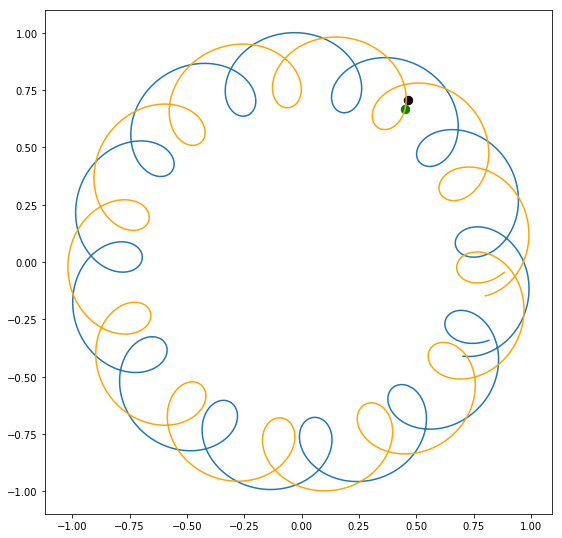

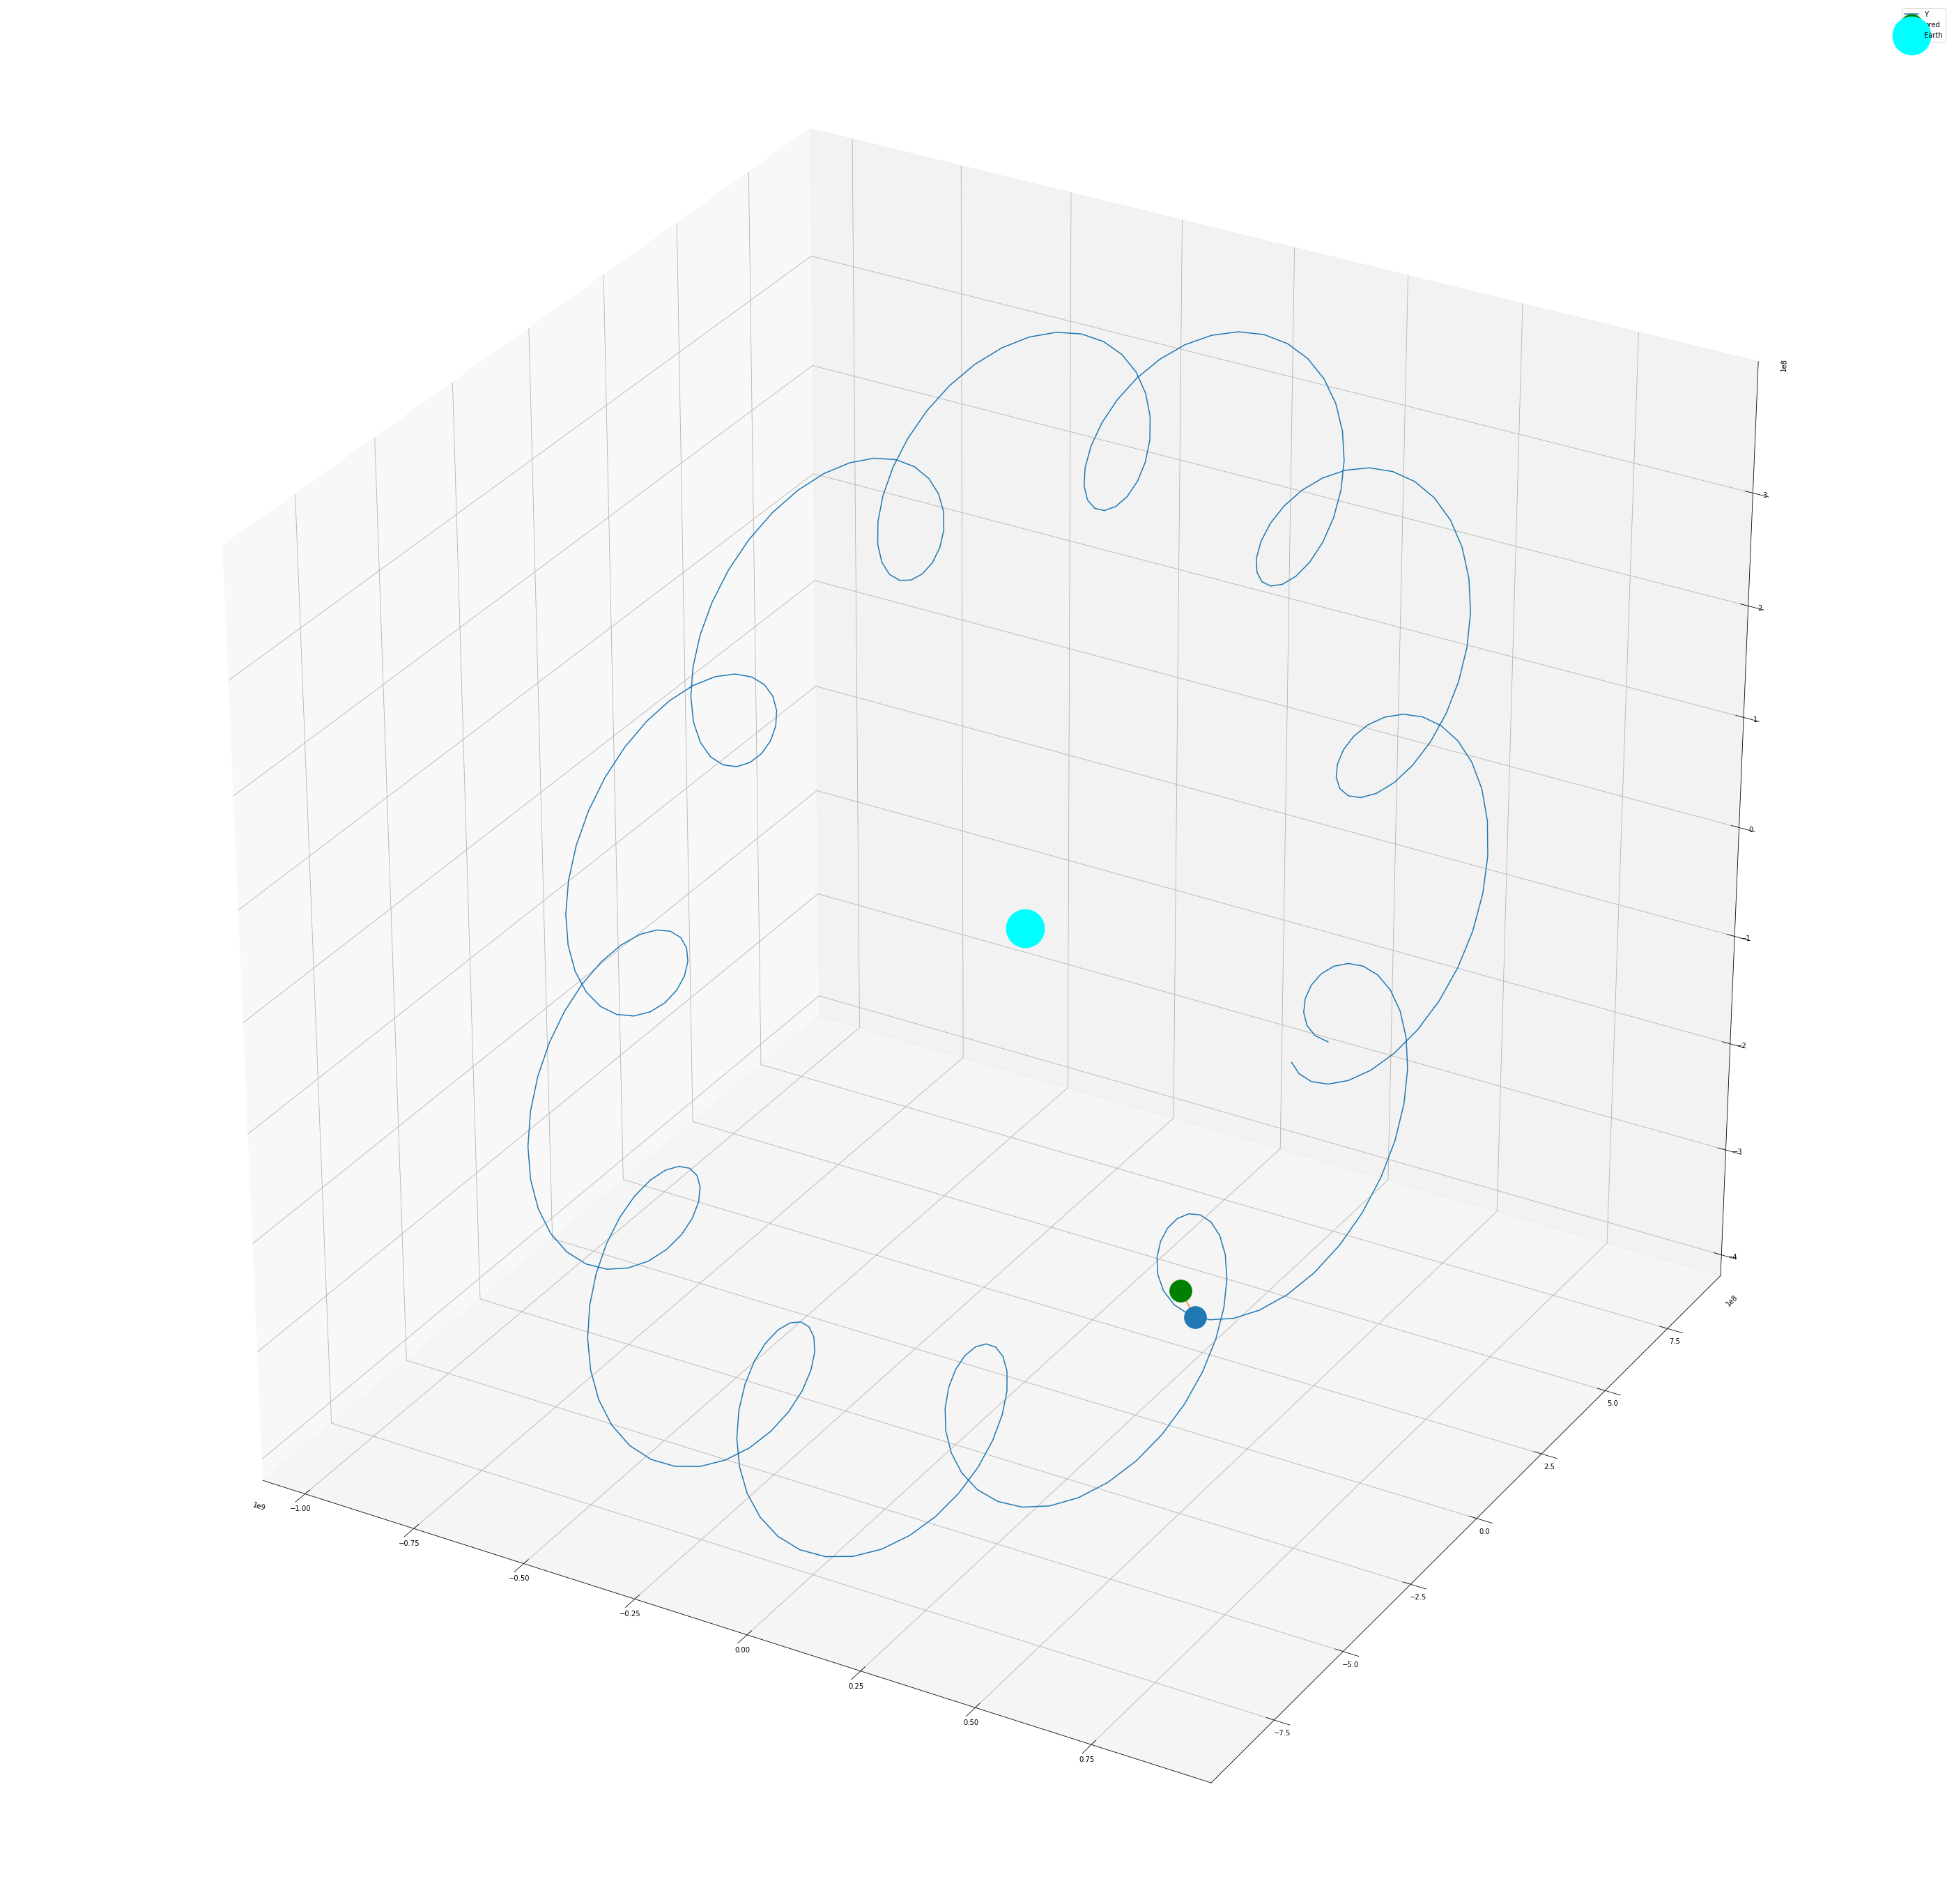

In [62]:
tester = datetime.strptime(test_pnt, '%Y-%m-%d %H:%M:%S')
# goback = 
DD1 = timedelta(days=365)
end1 = tester + DD1
DD = timedelta(model.cycle_len)
start = end1 - DD
end_str = end1.strftime("%Y-%m-%d %H:%M:%S")
start_str = start.strftime("%Y-%m-%d %H:%M:%S")


surround_range = pd.date_range(start_str, end_str, periods=300)

x_test, y_test, flat2_x, flat2_y, test_row2 = process_test(planet, test_pnt,surround_range, rotheta, phi, normal, jup_train)
pred_3d, test_3d = format_points(preds, test_pnt, jup_train, normal)
model.plot(x_test, y_test, flat2_x, flat2_y,pred_3d, test_3d, test_row2,False)

## Results and Error Analysis

In [63]:
print("theta =", model.theta)
print("pred (green) = ", pred_3d)
print("actual (blue) =", test_3d)
# print("error =", (preds[0] - x_test)**2 +  (preds[1] - y_test)**2)
err = np.linalg.norm(test_3d - pred_3d)
print("error =", err, "km")

theta = -0.08643673699754989
pred (green) =  [ 5.81639761e+08 -3.91416630e+08 -1.70650661e+08]
actual (blue) = [618160492.1341441, -398378132.02323216, -187956061.01877692]
error = 41008574.48394118 km


## IGNORE CELLS BELOW - DATA EXLORATION

In [86]:
# flat = Rotate_z(np.array((test_row['X'][0], test_row['Y'][0], test_row['Z'][0])), -rotheta)
# flat = Rotate_y(flat, -phi)

# flat2 = Rotate_z(test_row2[['X', 'Y', 'Z']].to_numpy(), -rotheta)
# flat2 = Rotate_y(flat2, -phi)
# flat2_x = scale(flat2[:,0], upper=1, lower=-1) 
# flat2_y = scale(flat2[:,1], upper=1, lower=-1) 
# # flat2_x = 0
# # flat2_y= 0

# x_test=scale_test(flat[0], jup_train['X'])
# y_test=scale_test(flat[1], jup_train['Y'])
# model.plot2D(x_test, y_test, flat2_x, flat2_y, False)
# model.plot3D(x_test, y_test, flat2_x, flat2_y, False)



# print("theta =", model.theta)
# print("pred = ", preds)
# print("actual =", x_test, y_test)
# print("error =", (preds[0] - x_test)**2 +  (preds[1] - y_test)**2)
# # print(flat2)

In [85]:
# # predict 3D
# test_3d = reverse_z_alignment(flat, normal)
# unsc_x = unscale_test(preds[0], jup_train['X'], upper=np.max(jup_train['X']), lower=np.min(jup_train['X']))
# unsc_y = unscale_test(preds[1], jup_train['Y'], upper=np.max(jup_train['Y']), lower=np.min(jup_train['Y']))
# print(preds[0],unsc_x)
# new_pred = np.array([unsc_x, unsc_y])

# pred_3d = reverse_z_alignment(np.append(new_pred, np.zeros(1)) ,normal)
# fig = plt.figure(figsize=(50,50))
# ax = fig.gca(projection='3d')

# ax.scatter(pred_3d[0], pred_3d[1],pred_3d[2], label='pred', c='green', s=1000)
# ax.scatter(test_3d[0], test_3d[1],test_3d[2], s=1000)
# ax.scatter(0,0,0, s=3000, label='Earth', c='cyan')
# ax.plot(test_row2['X'], test_row2['Y'],test_row2['Z'])
# vec = np.vstack((pred_3d, test_3d))
# ax.plot(vec[:,0],vec[:,1],vec[:,2])
# plt.legend()
# plt.show()

# # ax.plot(['X'], data['Y'], data['Z'])

In [ ]:
# plt.plot(jup.index,jup['Z'])
# plt.show()

In [84]:

# x1 = x_scl[:train_n//2]
# y1 = y_scl[:train_n//2]
# x2 = x_scl[train_n//2:]
# y2 = y_scl[train_n//2:]

# x3 = x_scl_test[train_n//2:]
# y3 = y_scl_test[train_n//2:]

# start_time = datetime.strptime(jup_train.index[0][:19],'%Y-%m-%d %H:%M:%S')
# # then = datetime.strptime('2020-11-26','%Y-%m-%d')
# test_ind = 1300

# test_time = datetime.strptime(jup_test.index[test_ind][:19],'%Y-%m-%d %H:%M:%S')
#                         # N
# duration = test_time - start_time                         # For build-in functions
# time_diff = duration.total_seconds()/(3600*24) 
# # print(duration_in_d)

# cycle_len = (datetime.strptime(jup_train.index[len(x1)][:10],'%Y-%m-%d') - 
#                         datetime.strptime(jup_train.index[0][:10],'%Y-%m-%d')).total_seconds()/(3600*24) 
# # t_test = 2*np.pi*(time_diff/cycle_len)
# cycle_shift = np.floor(time_diff/cycle_len)
# cycle_dec = time_diff/cycle_len - np.floor(time_diff/cycle_len)

# # print(np.array(jup_test.iloc[test_ind,:]['X']))
# # tempx = x1.copy()
# # tempx = np.append(tempx,jup_test.iloc[test_ind,:]['X'])
# # tempy = y1.copy()
# # tempy = np.append(tempy,jup_test.iloc[test_ind,:]['Y'])



# # x_test_point = x3[test_ind - train_n//2]
# # x_test_point = scale_test(x2[test_ind], jup_train['X'])
# # # print("test", x_test_point, y_test_point)
# # # scale(tempx, upper=1, lower=-1)[-1]
# # y_test_point = scale_test(jup_test.iloc[test_ind]['Y'], jup_train['Y'])
# # y3[test_ind - train_n//2]


# # print(x1.shape, x2.shape)
# # thet = model.theta*cycle_shift
# thet = 0.25401758412428127
# R = np.array([[np.cos(thet), np.sin(thet)],
#               [-np.sin(thet), np.cos(thet)]])

# carts = np.vstack((x1, y1))
# carts2 = np.vstack((x2, y2))
# rot = R @ carts

# offset = 0
# adj = int(offset * cycle_shift)

# pred = rot[:, adj+int(np.ceil(len(x1) * cycle_dec))]

# two_norm = (1/train_n) * np.sum(np.linalg.norm((rot - carts2), axis=0))

# # print(two_norm)
# # print((rot - carts2).shape)
# fig2 = plt.figure(figsize=(20,20))
# ax2 = fig2.add_subplot(121)


# ax2.plot(x1, y1, label='train')
# ax2.plot(x2, y2, label='train2')
# # ax2.plot(rot[0, :], rot[1, :], c = 'orange', label='rotation (pred)')
# # ax2.plot(x2,y2,c='r',label='test'
# c =50

# ax2.scatter(x1[c], y1[c], c='black', label='1st')
# ax2.scatter(x2[0], y2[0], c='green', label='2nd')

# # rotated train
# # ax2.plot(rot[0, :][:-35], rot[1, :][:-35], c = 'orange', label='rotation')

# # test
# # ax2.plot(x3[adj:], y3[adj:],c='r',label='test')
# # ax2.scatter(x_test_point, y_test_point, c='black', label='test point')
# # ax2.scatter(pred[0], pred[1], c='green', label='predicted point')
# # ax2.scatter(x2[1515], y2[1515], c='green')
# # print(pred[0], pred[1])
# ax2.set_aspect('equal', adjustable="box")
# plt.legend()
# plt.show()

# # predict()

